## Different Lags

#### Config

In [ ]:
## load some packages
from pandas_datareader.fred import FredReader  # gets data without a bunch of csvs
from scipy.signal import detrend  # detrend series
import matplotlib.pyplot as plt  # make plots
import statsmodels.api as sm  # regressions
import numpy as np  # math things

# fonts look pretty
plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
    })

#### Data

In [2]:
## data config
start = '1960-01'
end = '2007-12'
series = {
        'GDPDEF': 'gdpdef',  # gdp deflator
        'GDP': 'gdp',  # gdp
        'GCE': 'gov',  # govt spending
        'W006RC1Q027SBEA': 'tax',  # tax revenues
    }

## pull data
## pull the data
df = FredReader(series.keys(), start=start, end=end).read().rename(columns=series).dropna()

## adjust series
df = df[['gdp', 'gov', 'tax']].div(df['gdpdef'], axis=0)
# predetrend, want to know how much higher gdp is than gov
# so when we know 1% change in gov -> 1% change in gdp we can muliply it by that
mult = (df['gdp'] / df['gov']).mean()
for x in df.columns:
    df[x] = detrend(np.log(df[x])) * 100

df

,gdp,gov,tax
DATE,,,
1960-01-01,-6.207381,-15.411893,2.433646
1960-04-01,-7.552969,-15.118566,-0.275316
1960-07-01,-7.866166,-12.774345,-2.048241
1960-10-01,-9.961823,-12.190004,-4.701228
1961-01-01,-10.095264,-11.569745,-5.804134
...,...,...,...
2006-10-01,-1.566638,2.143878,8.361621
2007-01-01,-2.070254,2.162052,9.050781
2007-04-01,-2.263960,2.676012,8.469576


#### Results
$A = $ matrix multiplied by movements ($u$)

$B = $ matrix multiplied by error ($\varepsilon$)

#### Model 1
Set $b_2 = 0$

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: gtol. After release 0.14, this will raise.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


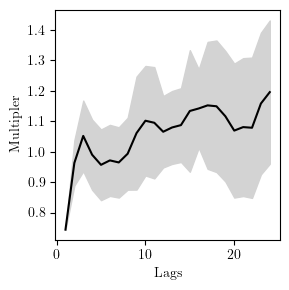

In [7]:
## config
ls = np.arange(1, 25)
A = np.array([[1, 'E', 'E'], [0, 1, 0], [1.7, 0, 1]])
B = np.array([[1, 0, 0], [0, 1, 0], [0, 'E', 1]])
T = 25
i = 2

## loop over lags, calcualte multiplier
multipliers = []
multiplier_errs = []
for l in ls:
    # calcaute svar
    svar = sm.tsa.SVAR(df, svar_type='AB', A=A, B=B).fit(maxlags=l, solver='newton')

    # get the irf
    irf = svar.irf(periods=T)
    g_irf = irf.svar_irfs[:, :, i].T  # irf for a g shock
    g_irf /= g_irf[2, 0]
    g_irf_err = irf.stderr()[:, :, i].T / g_irf[2, 0]  # error band

    ## get the multiplier
    idx = np.abs(g_irf[0]).argmax()
    max_gdp_change = g_irf[0, idx]
    max_gdp_stderr = g_irf_err[0, idx]
    multiplier = max_gdp_change * mult  # make comprable units
    multiplier_err = max_gdp_stderr * mult

    multipliers.append(multiplier)
    multiplier_errs.append(multiplier_err)
multipliers = np.array(multipliers)
multiplier_errs = np.array(multiplier_errs)

## plot it
fig, ax = plt.subplots()
fig.set_figwidth(3)
fig.set_figheight(3)
ax.set_ylabel('Multipler')
ax.set_xlabel('Lags')

# plot the data
ax.fill_between(
        ls,
        multipliers - multiplier_errs,
        multipliers + multiplier_errs,
        color='lightgray',
    )
ax.plot(ls, multipliers, 'k-')

## final things
fig.tight_layout()
fig.savefig('paper/figures/b20_lags.pdf')

#### Model 2
Set $c_2 = 0$

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method ncg is: fhess_p, avextol, epsilon. The list of unsupported keyword arguments passed include: gtol. After release 0.14, this will raise.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, f

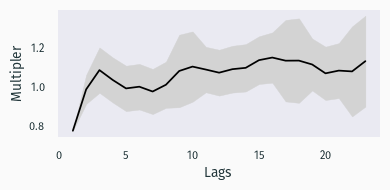

In [ ]:
## config
ls = np.arange(1, 24)
A = np.array([[1, 'E', 'E'], [0, 1, 0], [1.7, 0, 1]])
B = np.array([[1, 0, 0], [0, 1, 'E'], [0, 0, 1]])
T = 25
i = 2

## loop over lags, calcualte multiplier
multipliers = []
multiplier_errs = []
for l in ls:
    # calcaute svar
    svar = sm.tsa.SVAR(df, svar_type='AB', A=A, B=B).fit(maxlags=l, solver='ncg')

    # get the irf
    irf = svar.irf(periods=T)
    g_irf = irf.svar_irfs[:, :, i].T  # irf for a g shock
    g_irf /= g_irf[2, 0]
    g_irf_err = irf.stderr()[:, :, i].T / g_irf[2, 0]  # error band

    ## get the multiplier
    idx = np.abs(g_irf[0]).argmax()
    max_gdp_change = g_irf[0, idx]
    max_gdp_stderr = g_irf_err[0, idx]
    multiplier = max_gdp_change * mult  # make comprable units
    multiplier_err = max_gdp_stderr * mult

    multipliers.append(multiplier)
    multiplier_errs.append(multiplier_err)
multipliers = np.array(multipliers)
multiplier_errs = np.array(multiplier_errs)

## plot it
fig, ax = plt.subplots()
fig.set_figwidth(3)
fig.set_figheight(3)
ax.set_ylabel('Multipler')
ax.set_xlabel('Lags')

# plot the data
ax.fill_between(
        ls,
        multipliers - multiplier_errs,
        multipliers + multiplier_errs,
        color='lightgray',
    )
ax.plot(ls, multipliers, 'k-')

## final things
fig.tight_layout()
fig.savefig('paper/figures/c20_lags.pdf')